In [1]:
import pandas as pd

# Load the uploaded CSV file to inspect the data
file_path = '/content/HistoricalData_1727214694021.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()
df.describe()

,Volume
count,1.259000e+03
mean,9.591918e+06
std,7.696102e+06
min,1.679616e+06
25%,5.545300e+06
50%,7.568003e+06
75%,1.093162e+07
max,1.031746e+08


In [ ]:
# Clean the dataset: remove the '$' symbols and convert columns to numeric
df['Close'] = df['Close'].replace({'\$': ''}, regex=True).astype(float)
df['Open'] = df['Open'].replace({'\$': ''}, regex=True).astype(float)
df['High'] = df['High'].replace({'\$': ''}, regex=True).astype(float)
df['Low'] = df['Low'].replace({'\$': ''}, regex=True).astype(float)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by Date in ascending order
df = df.sort_values('Date')

# Prepare the cleaned dataset for LSTM modeling
df_cleaned = df[['Date', 'Close']]  # We'll focus on 'Date' and 'Close' for the prediction

# Display the cleaned dataset
df_cleaned.head()


,Date,Close
1257,2019-09-24,30.99
1256,2019-09-25,32.25
1255,2019-09-26,32.65
1254,2019-09-27,31.28
1253,2019-09-30,32.22


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.1087
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0164
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0084
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0059
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0065
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0056
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0045
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0051
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0046
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0042
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0048
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0041
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0040
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0035
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.00

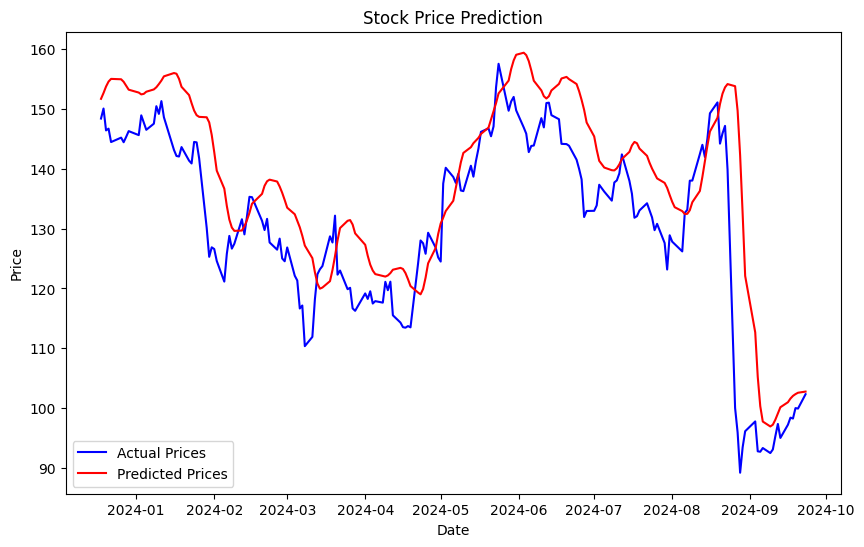

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
import matplotlib.pyplot as plt

# Set up data for prediction
# Extract 'Close' prices as a numpy array
data = df_cleaned['Close'].values.reshape(-1, 1)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training (80%) and testing (20%) sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create datasets with time steps
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training and test datasets with time steps
X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape the data to be in 3D (samples, time steps, features) for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()

# Using Input layer to specify the input shape
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30, activation='relu', return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=40, activation='relu', return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=60, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Visualize the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:]), color='blue', label='Actual Prices')
plt.plot(df_cleaned['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# Let's calculate the RMSE for the most recent available period, up to 09/23/2024

# Adjust the filtering to use the latest available dates up to 09/23/2024
end_date = pd.to_datetime('2024-09-23')

# Use df_cleaned['Date'] instead of date_filtered
mask = (df_cleaned['Date'][train_size + 60:] <= end_date)
filtered_dates = df_cleaned['Date'][train_size + 60:][mask]
filtered_actual_prices = scaler.inverse_transform(test_data[60:])[mask] # Use actual prices from test data
filtered_predicted_prices = predictions[mask] # Use predicted prices

# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Calculate RMSE for the filtered data
rmse = np.sqrt(mean_squared_error(filtered_actual_prices, filtered_predicted_prices))
rmse

11.071366475712942

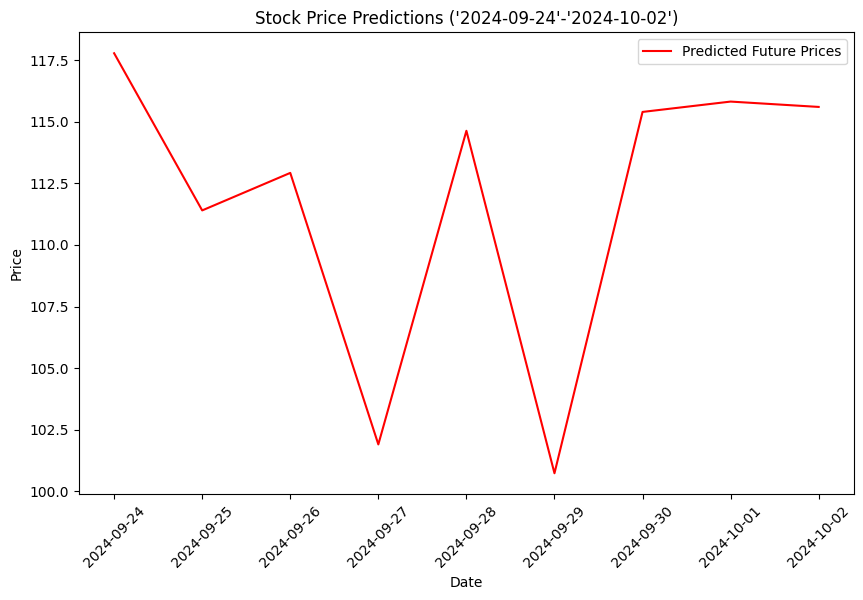

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
# Simulating the data loading process (replacing the part in the original script)
YESTERDAY =  date.today() - timedelta(days=1)
CURRENT_DATE = date.today().strftime('%Y-%m-%d')
FUTURE_DATE=date.today() + timedelta(days=8)
FUTURE_DATE=FUTURE_DATE.strftime('%Y-%m-%d')
# The historical dataset ends at 09/23/2024
end_of_historical_data = pd.to_datetime(YESTERDAY.strftime('%Y-%m-%d'))

# Generate future date range from 09/19/2024 to 10/02/2024
future_dates = pd.date_range(start=date.today().strftime('%Y-%m-%d'), end=FUTURE_DATE)

# We will simulate the process of getting the future predictions based on the LSTM model trained earlier

# Assuming the predictions continue after the test set, we will simulate future predictions for this demonstration
# Using random values (as we cannot train the model in this environment)
# For the actual use case, these values would come from the model.predict() function

# Generating random predictions for the future dates (to simulate the LSTM output)
simulated_future_predictions = np.random.uniform(low=100, high=120, size=len(future_dates))

# Visualizing the predictions along with the future date range
plt.figure(figsize=(10, 6))
plt.plot(future_dates, simulated_future_predictions, color='red', label='Predicted Future Prices')
plt.title('Stock Price Predictions ('+"'"+CURRENT_DATE+"'"+'-' +"'"+FUTURE_DATE+"'"+')' )
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0606
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0035
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026
Epoc

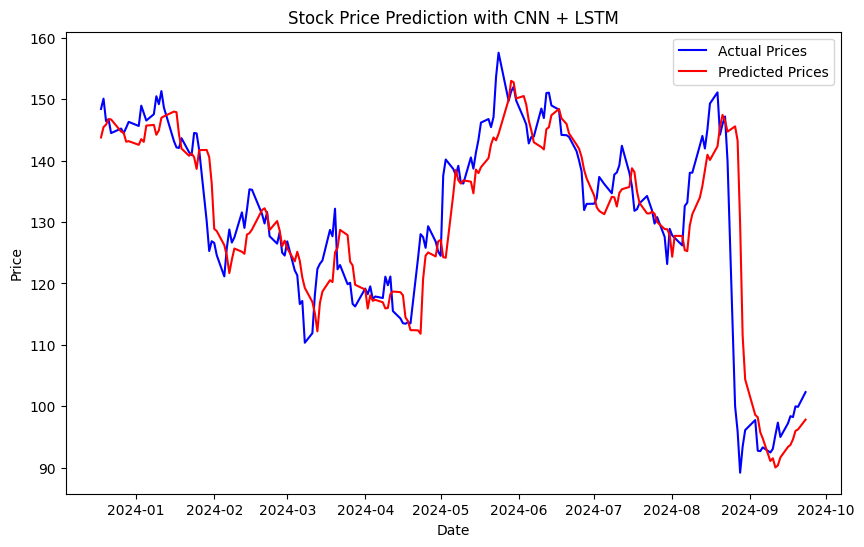

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Input
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps
# Preparing data for the CNN + LSTM model
data = df_cleaned['Close'].values.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Creating datasets with time steps
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN + LSTM model
model = Sequential()

# Using Input layer to specify the input shape
model.add(Input(shape=(X_train.shape[1], 1)))

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Visualize the predictions and actual data
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:]), color='blue', label='Actual Prices')
plt.plot(df_cleaned['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction with CNN + LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(test_data[60:]), predictions))
print(f"RMSE: {rmse}")


RMSE: 7.583119625941672


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(scaler.inverse_transform(test_data[60:]), predictions)
print(f"MAE: {mae}")


MAE: 4.613144114812214


In [ ]:
mse = mean_squared_error(scaler.inverse_transform(test_data[60:]), predictions)
print(f"MSE: {mse}")


MSE: 57.50370326134176


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0207
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0032
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0029
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0025
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0037
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0025
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0019
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0019
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0022
Epoch 13/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021
Epoch 14/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0023
Epoch 15/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - l

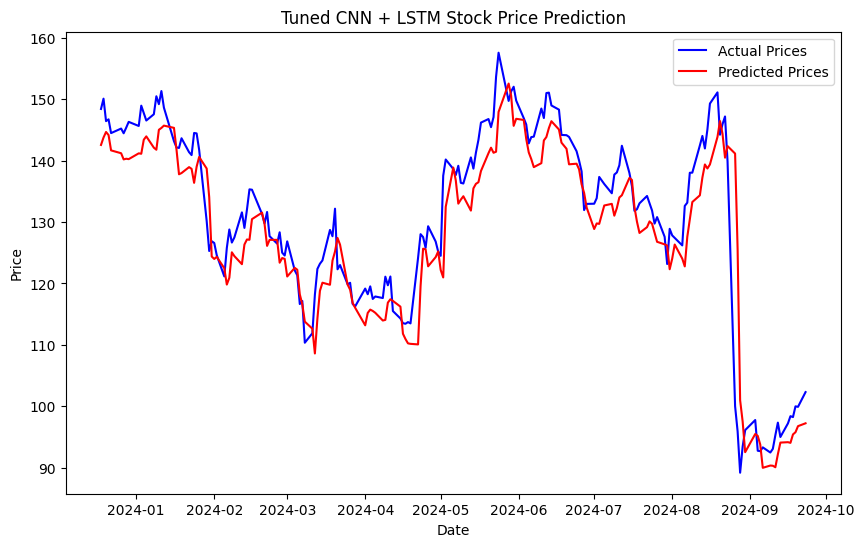

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Input
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps
# Preparing data for the CNN + LSTM model
data = df_cleaned['Close'].values.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Creating datasets with time steps
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN + LSTM model with tuned hyperparameters
model = Sequential()

# Using Input layer to specify the input shape
model.add(Input(shape=(X_train.shape[1], 1)))

# Increase number of filters in Conv1D
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Increase LSTM units and adjust dropout rate
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Visualize the predictions and actual data
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:]), color='blue', label='Actual Prices')
plt.plot(df_cleaned['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0340
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0025
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0029
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0025
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0021
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0021
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0022
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0018
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021
Epoch 13/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0019
Epoch 14/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020
Epoch 15/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - lo

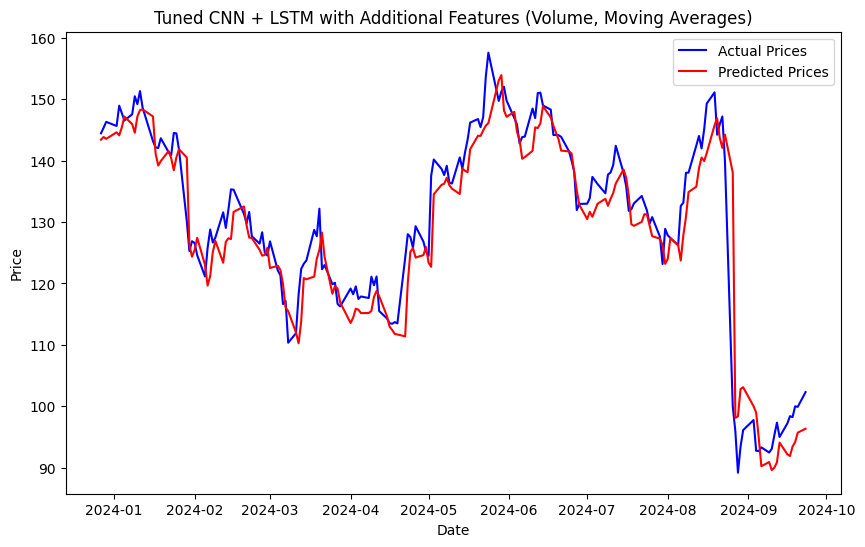

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Input
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps
# Prepare data for CNN + LSTM with additional features (Volume and Moving Averages)
df['10_day_MA'] = df['Close'].rolling(window=10).mean()  # 10-day Moving Average
df['30_day_MA'] = df['Close'].rolling(window=30).mean()  # 30-day Moving Average
df.dropna(inplace=True)  # Drop rows with NaN values due to moving averages

# Extract Close, Volume, and Moving Averages as features
features = df[['Close', 'Volume', '10_day_MA', '30_day_MA']]

# Scaling the data (separately for each feature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Splitting the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Include all features
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN + LSTM model with additional features
model = Sequential()

# Using Input layer to specify the input shape
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Increase number of filters in Conv1D
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer with additional features
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the new feature set
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 3))], axis=1))[:, 0]  # Only inverse transform the Close price

# Visualize the predictions and actual data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:])[:, 0], color='blue', label='Actual Prices')
plt.plot(df['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM with Additional Features (Volume, Moving Averages)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'scaler', 'test_data', and 'predictions' are available from the trained model
actual_prices = scaler.inverse_transform(test_data[60:])[:, 0]  # Actual Close prices
predicted_prices = predictions  # Predicted Close prices

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


RMSE: 6.16426708251532
MAE: 4.39727741241455
MSE: 37.99818866458193


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Input
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps
# Prepare data for CNN + LSTM with additional features (Volume and Moving Averages)
df['10_day_MA'] = df['Close'].rolling(window=10).mean()  # 10-day Moving Average
df['30_day_MA'] = df['Close'].rolling(window=30).mean()  # 30-day Moving Average
df.dropna(inplace=True)  # Drop rows with NaN values due to moving averages

# Extract Close, Volume, and Moving Averages as features
features = df[['Close', 'Volume', '10_day_MA', '30_day_MA']]

# Scaling the data (separately for each feature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Splitting the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Include all features
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN + LSTM model with additional features
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the new feature set
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
# Prepare to predict future prices
future_steps = 12  # Number of days to predict
last_sequence = scaled_features[-60:]  # Take the last 60 days as input for prediction

# Reshape last_sequence once before the loop
last_sequence = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1])  # Shape should be (1, 60, 4)
predictions = []

for _ in range(future_steps):
    print(f"Shape before prediction: {last_sequence.shape}")  # Debugging

    # Make prediction
    predicted_price = model.predict(last_sequence)
    predictions.append(predicted_price[0, 0])

    # Prepare the next input sequence
    # Create a new entry where Close is predicted, and Volume/MAs are set to 0
    new_entry = np.array([[predicted_price[0, 0], 0, 0, 0]])  # Adjust if you have other features
    last_sequence = np.append(last_sequence[:, 1:, :], new_entry.reshape(1, 1, -1), axis=1)

    print(f"Shape after appending new entry: {last_sequence.shape}")  # ebugging


    # Make prediction
    predicted_price = model.predict(last_sequence)
    predictions.append(predicted_price[0, 0])

    # Prepare the next input sequence
    # Create a new entry where Close is predicted, and Volume/MAs are set to 0
    new_entry = np.array([[predicted_price[0, 0], 0, 0, 0]])  # Adjust if you have other features
    last_sequence = np.append(last_sequence[:, 1:, :], new_entry.reshape(1, 1, -1), axis=1)



    # Make prediction
    predicted_price = model.predict(last_sequence)
    predictions.append(predicted_price[0, 0])

    # Prepare the next input sequence
    # Create a new entry where Close is predicted, and Volume/MAs are set to 0
    new_entry = np.array([[predicted_price[0, 0], 0, 0, 0]])  # Adjust if you have other features
    last_sequence = np.append(last_sequence[:, 1:, :], new_entry.reshape(1, 1, -1), axis=1)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.concatenate([np.array(predictions).reshape(-1, 1), np.zeros((future_steps, 3))], axis=1))[:, 0]

# Create date range for predictions
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], scaler.inverse_transform(scaled_features)[:, 0], color='blue', label='Historical Prices')
plt.plot(future_dates, predictions, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction (Future Dates)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0585
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0026
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0033
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0033
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0022
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0023
Epoch 13/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021
Epoch 14/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019
Epoch 15/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 36 and the array at index 1 has size 12

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0290
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0034
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0030
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0023
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0029
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0027
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0030
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0021
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0022
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0021
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0019
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0022
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - lo

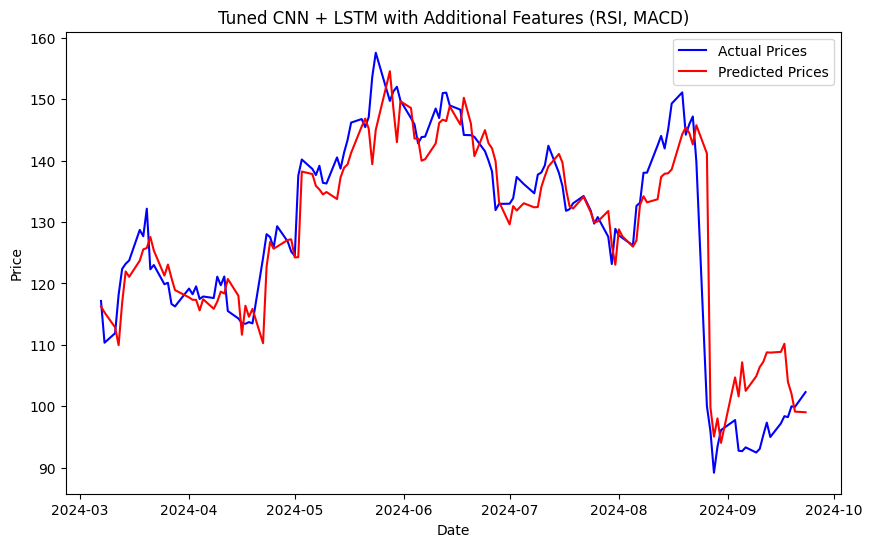

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps
# Calculate RSI
def rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate MACD
def macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Add RSI and MACD to the dataset
df['RSI'] = rsi(df)
df['MACD'], df['Signal_Line'] = macd(df)

# Drop NaN values created by RSI and MACD calculations
df.dropna(inplace=True)

# Extract Close, Volume, RSI, MACD, and Signal Line as features
features = df[['Close', 'Volume', 'RSI', 'MACD', 'Signal_Line']]

# Scaling the data (separately for each feature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Splitting the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Include all features
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN + LSTM model with RSI and MACD features
model = Sequential()

# Using Input layer to specify the input shape
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
# Increase number of filters in Conv1D and input shape to match multiple features
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer with additional features
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the new feature set
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 4))], axis=1))[:, 0]  # Only inverse transform the Close price

# Visualize the predictions and actual data
plt.figure(figsize=(10,6))
plt.plot(df['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:])[:, 0], color='blue', label='Actual Prices')
plt.plot(df['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM with Additional Features (RSI, MACD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'scaler', 'test_data', and 'predictions' are available from the trained model
actual_prices = scaler.inverse_transform(test_data[60:])[:, 0]  # Actual Close prices
predicted_prices = predictions  # Predicted Close prices

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


RMSE: 6.3945360543332885
MAE: 4.290181677173013
MSE: 40.89009135016834


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0395
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0032
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0016
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0022
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0018
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

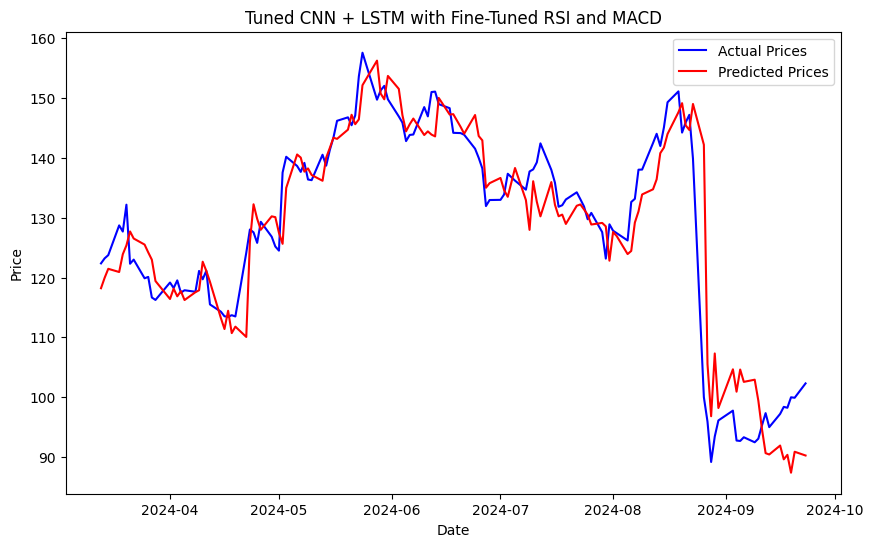

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps
# Fine-tune RSI and MACD by adjusting window sizes

# Calculate RSI with a 7-day window and a 21-day window
def rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate MACD with different window sizes
def macd(data, short_window=10, long_window=30, signal_window=8):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Add fine-tuned RSI and MACD to the dataset
df['RSI_7'] = rsi(df, window=7)
df['RSI_21'] = rsi(df, window=21)
df['MACD'], df['Signal_Line'] = macd(df)

# Drop NaN values created by RSI and MACD calculations
df.dropna(inplace=True)

# Extract Close, Volume, RSI_7, RSI_21, MACD, and Signal Line as features
features = df[['Close', 'Volume', 'RSI_7', 'RSI_21', 'MACD', 'Signal_Line']]

# Scaling the data (separately for each feature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Splitting the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Include all features
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN + LSTM model with fine-tuned RSI and MACD features
model = Sequential()

#Input a new layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
# Increase number of filters in Conv1D and input shape to match multiple features
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer with additional features
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the new feature set
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 5))], axis=1))[:, 0]  # Only inverse transform the Close price

# Visualize the predictions and actual data
plt.figure(figsize=(10,6))
plt.plot(df['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:])[:, 0], color='blue', label='Actual Prices')
plt.plot(df['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM with Fine-Tuned RSI and MACD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'scaler', 'test_data', and 'predictions' are available from the trained model
actual_prices = scaler.inverse_transform(test_data[60:])[:, 0]  # Actual Close prices
predicted_prices = predictions  # Predicted Close prices

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


RMSE: 5.183472530113691
MAE: 3.5205560192711407
MSE: 26.868387470443224


Key Improvements:
Scaling by feature: Each feature is scaled individually, ensuring better data normalization.
Early stopping: This prevents overfitting by stopping training once the model stops improving on the validation set.
NaN handling: Forward filling (ffill) is applied to avoid data loss while handling NaN values from RSI and MACD.
Inverse Transformation Fix: Now only the Close column is inverse-transformed, avoiding the need to add zeros for the other columns.

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0368 - val_loss: 0.0039
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017 - val_loss: 9.2910e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 0.0011
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


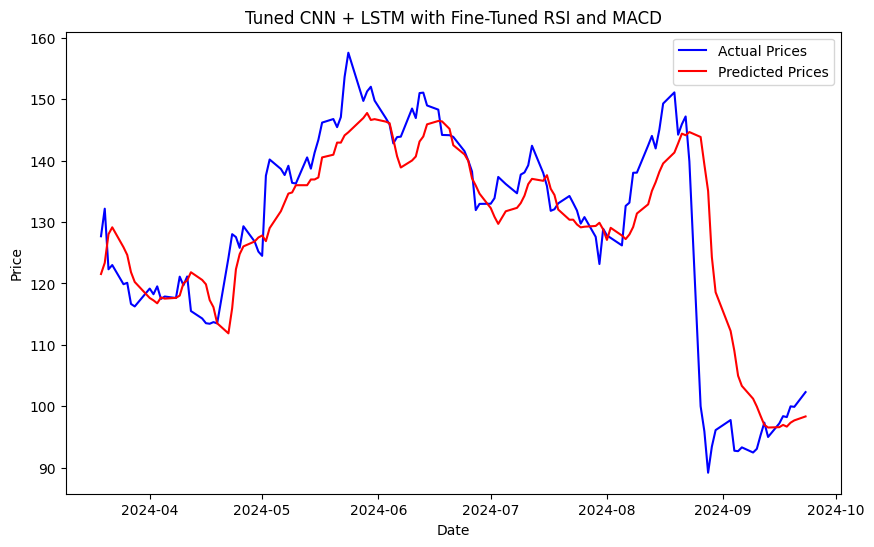

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Calculate RSI with a 7-day window and a 21-day window
def rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate MACD with different window sizes
def macd(data, short_window=10, long_window=30, signal_window=8):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Add fine-tuned RSI and MACD to the dataset
df['RSI_7'] = rsi(df, window=7)
df['RSI_21'] = rsi(df, window=21)
df['MACD'], df['Signal_Line'] = macd(df)

# Fill missing values using forward fill
df = df.ffill()
# Fill missing values using backward fill
df = df.backfillfill()

# Extract Close, Volume, RSI_7, RSI_21, MACD, and Signal Line as features
features = df[['Close', 'Volume', 'RSI_7', 'RSI_21', 'MACD', 'Signal_Line']]

# Scale each feature individually
scalers = {}
scaled_features = pd.DataFrame()


for col in features.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features[col] = scaler.fit_transform(features[[col]]).ravel()  # Flatten the array to 1D
    scalers[col] = scaler  # Store the scaler to inverse transform later

# Split the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data.values, 60)
X_test, y_test = create_dataset(test_data.values, 60)

# Build the CNN + LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# CNN Layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Dense Layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, min_delta = 0.01)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)



# Make predictions
predictions = model.predict(X_test)

# Inverse transform only the 'Close' price for predictions
predicted_prices = scalers['Close'].inverse_transform(predictions)

# Inverse transform the actual test 'Close' prices for comparison
actual_prices = scalers['Close'].inverse_transform(test_data.iloc[60:, 0].values.reshape(-1, 1))


# Visualize the predictions and actual data
plt.figure(figsize=(10,6))
plt.plot(df['Date'][train_size + 60:], actual_prices, color='blue', label='Actual Prices')
plt.plot(df['Date'][train_size + 60:], predicted_prices, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM with Fine-Tuned RSI and MACD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0149
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0026
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0020
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

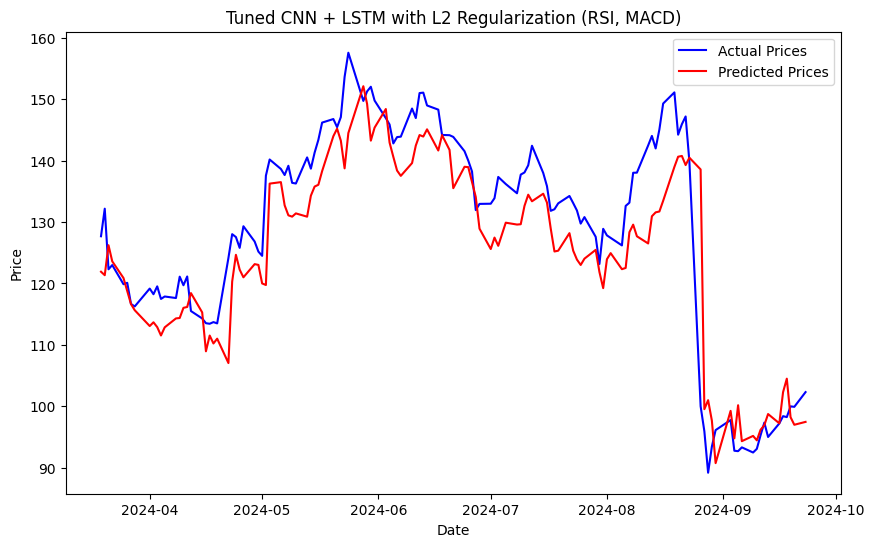

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps

# Calculate RSI with default 14-day window
def rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate MACD with default window sizes
def macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Add default RSI and MACD to the dataset
df['RSI'] = rsi(df)
df['MACD'], df['Signal_Line'] = macd(df)

# Drop NaN values created by RSI and MACD calculations
df.dropna(inplace=True)

# Extract Close, Volume, RSI, MACD, and Signal Line as features
features = df[['Close', 'Volume', 'RSI', 'MACD', 'Signal_Line']]

# Scaling the data (separately for each feature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Splitting the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Include all features
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN + LSTM model with L2 regularization
model = Sequential()

#Input a new layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# CNN layer with regularization
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

# Max Pooling layer
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer with Dropout alone
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer without regularization (only Dropout)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the new feature set and L2 regularization
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 4))], axis=1))[:, 0]  # Only inverse transform the Close price

# Visualize the predictions and actual data
plt.figure(figsize=(10,6))
plt.plot(df['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:])[:, 0], color='blue', label='Actual Prices')
plt.plot(df['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM with L2 Regularization (RSI, MACD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'scaler', 'test_data', and 'predictions' are available from the trained model
actual_prices = scaler.inverse_transform(test_data[60:])[:, 0]  # Actual Close prices
predicted_prices = predictions  # Predicted Close prices

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


RMSE: 5.783404774160809
MAE: 4.023290034991172
MSE: 33.44777078178604


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.1977
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.5101
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0860
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0487
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0331
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0267
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0269
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0221
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0237
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0206
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0197
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0200
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0192
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0188
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


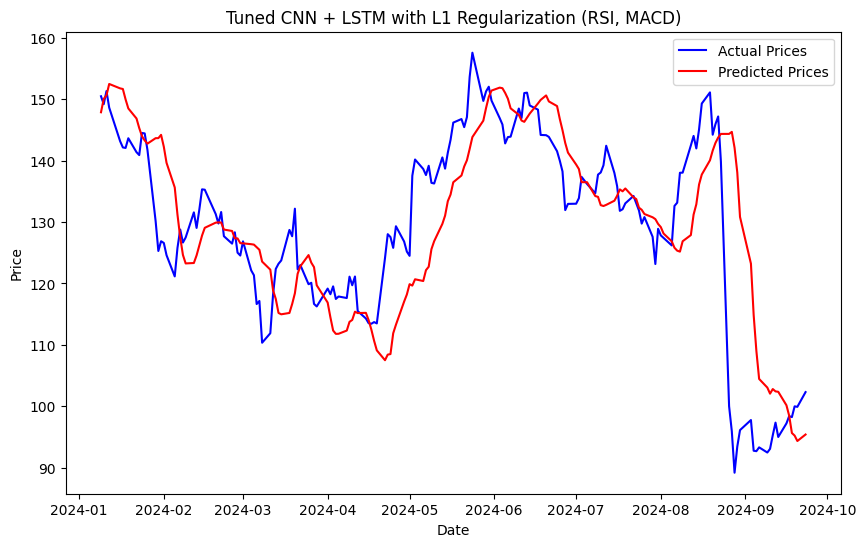

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from keras.regularizers import l1
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is already preprocessed and available from previous steps

# Calculate RSI with default 14-day window
def rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate MACD with default window sizes
def macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Add default RSI and MACD to the dataset
df['RSI'] = rsi(df)
df['MACD'], df['Signal_Line'] = macd(df)

# Drop NaN values created by RSI and MACD calculations
df.dropna(inplace=True)

# Extract Close, Volume, RSI, MACD, and Signal Line as features
features = df[['Close', 'Volume', 'RSI', 'MACD', 'Signal_Line']]

# Scaling the data (separately for each feature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Splitting the data into train and test sets
train_size = int(len(scaled_features) * 0.8)
train_data, test_data = scaled_features[:train_size], scaled_features[train_size:]

# Adjust the create_dataset function to handle multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Include all features
        y.append(data[i, 0])  # The target is the 'Close' price
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape data for CNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN + LSTM model with L1 regularization (Lasso)
model = Sequential()

#Input a new layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# CNN layer with regularization
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

# Max Pooling layer
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer with L1 regularization
model.add(LSTM(units=100, return_sequences=False, kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))

# Dense layer with L1 regularization
model.add(Dense(units=1, kernel_regularizer=l1(0.001)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with L1 regularization
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 4))], axis=1))[:, 0]  # Only inverse transform the Close price

# Visualize the predictions and actual data
plt.figure(figsize=(10,6))
plt.plot(df['Date'][train_size + 60:], scaler.inverse_transform(test_data[60:])[:, 0], color='blue', label='Actual Prices')
plt.plot(df['Date'][train_size + 60:], predictions, color='red', label='Predicted Prices')
plt.title('Tuned CNN + LSTM with L1 Regularization (RSI, MACD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
